<a href="https://colab.research.google.com/github/LuciaHrovatin/Credit_Analytics/blob/main/CreditAnalytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>

# Credit Analytics
## Project 1
### CAS Introduction to Machine Learning in Finance and Insurance (Spring 2025)
#### Navarro Diego - <href>dnavarro@ethz.ch</href>
#### Rizzi Michele - <href>mirizzi@ethz.ch</href>
#### Hrovatin Lucia - <href>lhrovatin@ethz.ch</href>

</center>

In [1]:
# Import all the Python libraries we are going to use

# Data Transformation
import numpy as np
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Statistical learning
from scipy.stats import bernoulli
from sklearn import preprocessing
from sklearn import metrics # evaluation metric
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression # logistic regression model
from sklearn.metrics import log_loss # evaluation metric
from sklearn.metrics import roc_curve # evaluation metric
from sklearn.metrics import roc_auc_score # evaluation metric
from sklearn.metrics import classification_report # evaluation metric

# Deep Learning
try:
    import keras
except ImportError:
    !pip install keras --quiet
    import keras

try:
    import keras_tuner
except ImportError:
    !pip install keras-tuner --quiet
    import keras_tuner


2025-05-11 22:37:30.093172: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
### Fix random seed for reproducibility
random_seed = 1024
np.random.seed(random_seed)

# Exercise 1. Dataset features generation.

In [3]:
# Number of samples
m = 20000  # training set
n = 10000  # test set

# Total number of samples
total_samples = m + n

# Generate xi1: age from the uniform distribution on [18, 80]
x1 = np.random.uniform(18, 80, total_samples)

# Generate xi2: monthly income (in CHF 1000) from the uniform distribution on [1, 15]
x2 = np.random.uniform(1, 15, total_samples)

# Generate xi3: salaried/self-employed in {0, 1}, where 0=salaried and 1=self-employed (probability of being self-employed is 10%)
x3 = np.random.choice([0, 1], total_samples, p=[0.9, 0.1])

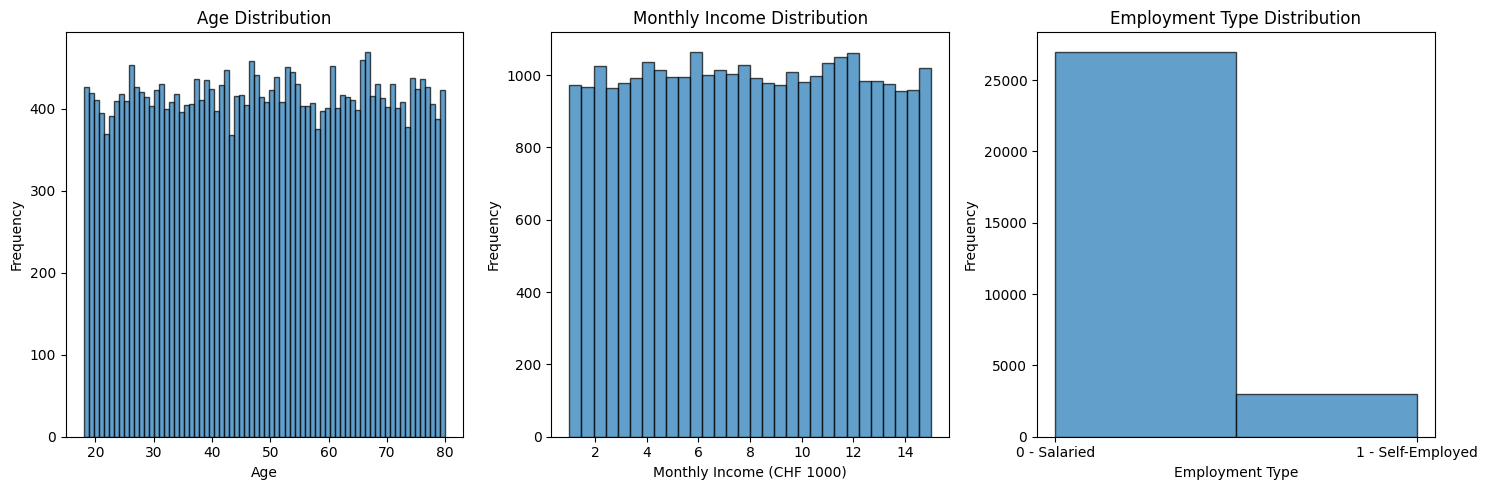

In [4]:
# Plot histograms for each feature in the dataset
plt.figure(figsize=(15, 5))

# Histogram for xi1: age
plt.subplot(1, 3, 1)
plt.hist(x1, bins=72, edgecolor='k', alpha=0.7)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Histogram for xi2: monthly income
plt.subplot(1, 3, 2)
plt.hist(x2, bins=30, edgecolor='k', alpha=0.7)
plt.title('Monthly Income Distribution')
plt.xlabel('Monthly Income (CHF 1000)')
plt.ylabel('Frequency')

# Histogram for xi3: salaried/self-employed
plt.subplot(1, 3, 3)
plt.hist(x3, bins=2, edgecolor='k', alpha=0.7)
plt.title('Employment Type Distribution')
plt.xlabel('Employment Type')
plt.ylabel('Frequency')
plt.xticks((0,1), ['0 - Salaried', '1 - Self-Employed'])

plt.tight_layout()
plt.show()

# Exercise 2. Dataset labels generation.

In [5]:
# Define logistic function
sigmoid = lambda z: 1 / (1 + np.exp(-z))

# Probability functions
p1 = sigmoid(-13.3 + 0.33*x1 - 3.5*x2 + 3*x3)

p2 = sigmoid(-5 + 10*((x1<25) | (x1>75)) - 1.1*x2 + x3)

# Generate labels
y1 = np.random.binomial(1, p1)
y2 = np.random.binomial(1, p2)

# Create dataframes for the labels
df1 = pd.DataFrame({'Age': x1, 'Income': x2, 'Self-employed': x3, 'Default': y1})
df2 = pd.DataFrame({'Age': x1, 'Income': x2, 'Self-employed': x3, 'Default': y2})

In [6]:
# Divide the dataset into training and test sets
training_set_x, test_set_x = np.stack([x1, x2, x3], axis=1)[:m], np.stack([x1, x2, x3], axis=1)[m:]
training_set_y1, test_set_y1 = y1[:m], y1[m:]
training_set_y2, test_set_y2 = y2[:m], y2[m:]

# Features normalization
scaler = preprocessing.StandardScaler()
training_set_x = scaler.fit_transform(training_set_x)
test_set_x = scaler.transform(test_set_x)

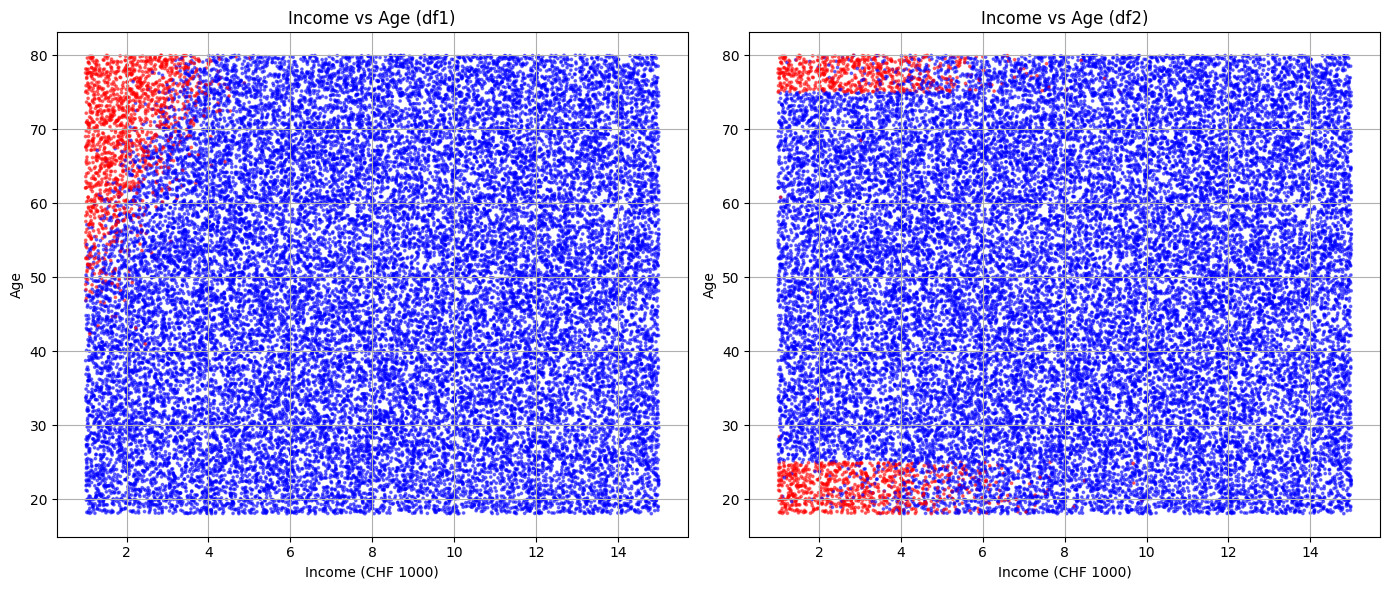

In [7]:
plt.figure(figsize=(14, 6))

# Scatter plot for df1
plt.subplot(1, 2, 1)
colors = {0: 'blue', 1: 'red'}
plt.scatter(df1['Income'], df1['Age'], c=df1['Default'].apply(lambda x: colors[x]), alpha=0.5, s=3)
plt.title('Income vs Age (df1)')
plt.xlabel('Income (CHF 1000)')
plt.ylabel('Age')
plt.grid(True)

# Scatter plot for df2
plt.subplot(1, 2, 2)
plt.scatter(df2['Income'], df2['Age'], c=df2['Default'].apply(lambda x: colors[x]), alpha=0.5, s=3)
plt.title('Income vs Age (df2)')
plt.xlabel('Income (CHF 1000)')
plt.ylabel('Age')
plt.grid(True)

plt.tight_layout()
plt.show()

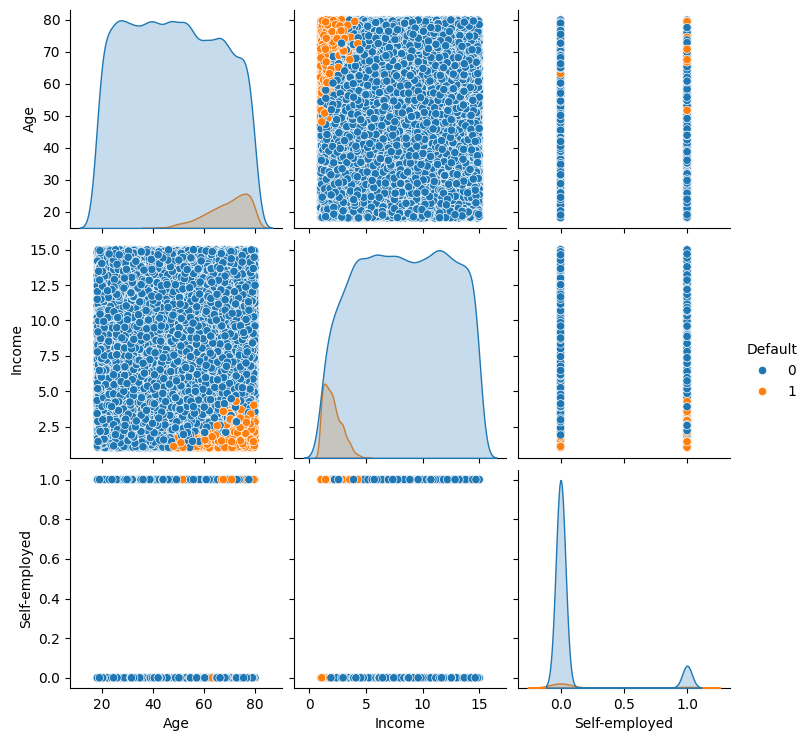

In [8]:
sns.pairplot(df1, hue='Default')
plt.show()

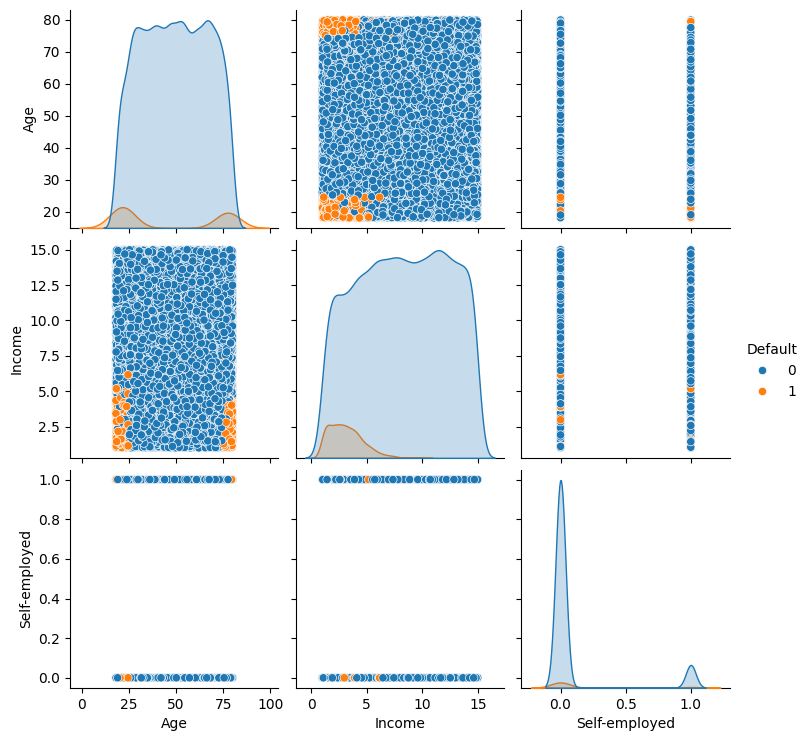

In [9]:
# Create a pairplot for df2
sns.pairplot(df2, hue='Default')
plt.show()

In [10]:
# Calculate ratio of default in train dataset
print(f'Default ratio: {y2[:m].mean():.4f}')

Default ratio: 0.0500


# Exercise 3. Model implementations.

### 3a) Logistic regression (LR)

In [11]:
# Implement and train a logistic regression model
logistic_regression_linear = LogisticRegression(penalty=None, random_state=random_seed).fit(training_set_x, training_set_y1)
logistic_regression_nonlinear = LogisticRegression(penalty=None, random_state=random_seed).fit(training_set_x, training_set_y2)

# Look at the parameters of the fitted model
print('Coefficients1:', logistic_regression_linear.coef_)
print('Intercept1:', logistic_regression_linear.intercept_)
print('Coefficients2:', logistic_regression_nonlinear.coef_)
print('Intercept2:', logistic_regression_nonlinear.intercept_)
# Predict the labels for the test set
predicted_y1 = logistic_regression_linear.predict(test_set_x)
predicted_y2 = logistic_regression_nonlinear.predict(test_set_x)

Coefficients1: [[  5.83968978 -13.56330471   0.92321213]]
Intercept1: [-24.05624864]
Coefficients2: [[-0.26284004 -2.07325486  0.1022799 ]]
Intercept2: [-4.45912478]


In [12]:
from sklearn.metrics import accuracy_score

def LR_tester(train_x, train_y, test_x, test_y, y_pred):
  # Define models
  models = {
    'No Penalty': LogisticRegression(penalty=None),
    'Ridge (L2)': LogisticRegression(penalty='l2', C=0.1, max_iter=10000),
  }
  for name, model in models.items():
      model.fit(train_x, train_y)
      y_pred = model.predict(test_x)
      acc = accuracy_score(test_y, y_pred)
      print(f"{name} Accuracy: {acc:.3f}")

# linear case
LR_tester(training_set_x, training_set_y1, test_set_x, test_set_y1, predicted_y1)

# non linear case
LR_tester(training_set_x, training_set_y2, test_set_x, test_set_y2, predicted_y2)

No Penalty Accuracy: 0.984
Ridge (L2) Accuracy: 0.983
No Penalty Accuracy: 0.954
Ridge (L2) Accuracy: 0.954


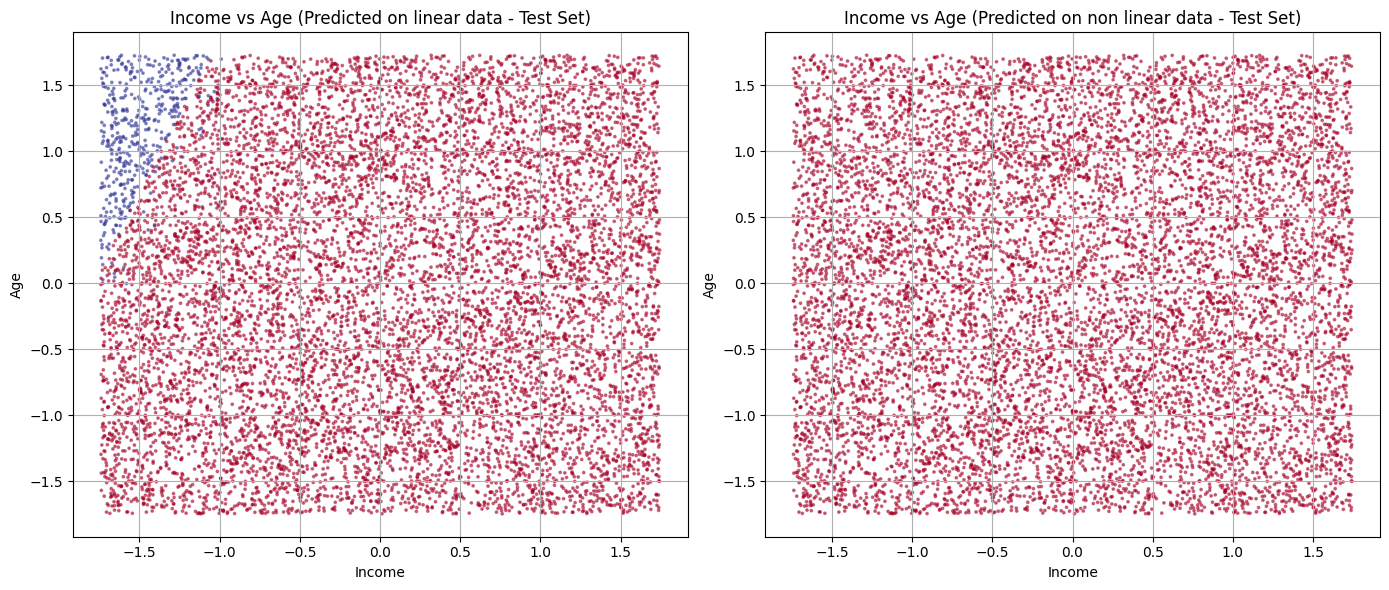

In [13]:
plt.figure(figsize=(14, 6))

# Scatter plot for predicted_y1
plt.subplot(1, 2, 1)
plt.scatter(test_set_x[:, 1], test_set_x[:, 0], c=predicted_y1, cmap=plt.cm.RdYlBu, alpha=0.5, s=3)
plt.title('Income vs Age (Predicted on linear data - Test Set)')
plt.xlabel('Income')
plt.ylabel('Age')
plt.grid(True)

# Scatter plot for predicted_y2( really bad!)
plt.subplot(1, 2, 2)
plt.scatter(test_set_x[:, 1], test_set_x[:, 0], c=predicted_y2, cmap=plt.cm.RdYlBu, alpha=0.5, s=3)
plt.title('Income vs Age (Predicted on non linear data - Test Set)')
plt.xlabel('Income')
plt.ylabel('Age')
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
# Compute cross-entropy loss for the training set
train_loss_y1 = log_loss(training_set_y1, logistic_regression_linear.predict_proba(training_set_x))
train_loss_y2 = log_loss(training_set_y2, logistic_regression_nonlinear.predict_proba(training_set_x))

# Compute cross-entropy loss for the test set
test_loss_y1 = log_loss(test_set_y1, logistic_regression_linear.predict_proba(test_set_x))
test_loss_y2 = log_loss(test_set_y2, logistic_regression_nonlinear.predict_proba(test_set_x))

print(f'Training Loss for y1: {train_loss_y1:.3f}')
print(f'Training Loss for y2: {train_loss_y2:.3f}')
print(f'Test Loss for y1: {test_loss_y1:.3f}')
print(f'Test Loss for y2: {test_loss_y2:.3f}')

Training Loss for y1: 0.033
Training Loss for y2: 0.149
Test Loss for y1: 0.033
Test Loss for y2: 0.142


Text(0.5, 36.72222222222221, 'Predicted label')

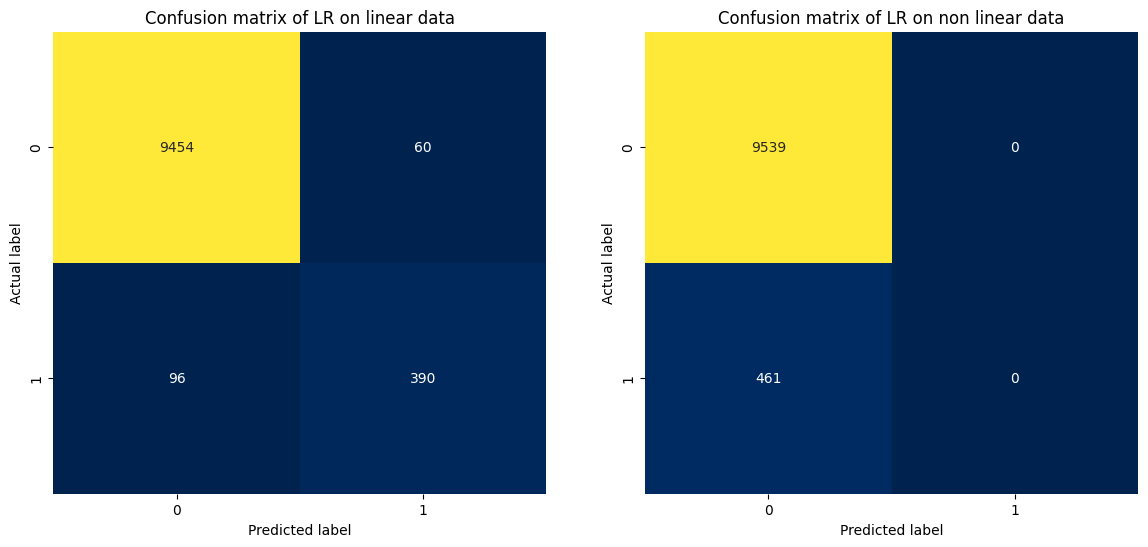

In [15]:
# Confusion Matrix of the models
plt.figure(figsize=(14, 6))
class_names=[0,1] # prediction names
tick_marks = np.arange(len(class_names))

# Confusion Matrix Linear
plt.subplot(1, 2, 1)
cnf_matrix = metrics.confusion_matrix(test_set_y1, predicted_y1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="cividis" ,fmt='g', cbar=False)
plt.title('Confusion matrix of LR on linear data')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Confusion Matrix nonLinear
plt.subplot(1, 2, 2)
cnf_matrix = metrics.confusion_matrix(test_set_y2, predicted_y2)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="cividis" ,fmt='g', cbar=False)
plt.title('Confusion matrix of LR on non linear data')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [16]:
import sklearn.metrics

target_names = ['no_loan', 'loan']
print(classification_report(test_set_y1, predicted_y1, target_names=target_names))
print(classification_report(test_set_y2, predicted_y2, target_names=target_names, zero_division=True, digits=3))



              precision    recall  f1-score   support

     no_loan       0.99      0.99      0.99      9514
        loan       0.87      0.80      0.83       486

    accuracy                           0.98     10000
   macro avg       0.93      0.90      0.91     10000
weighted avg       0.98      0.98      0.98     10000

              precision    recall  f1-score   support

     no_loan      0.954     1.000     0.976      9539
        loan      1.000     0.000     0.000       461

    accuracy                          0.954     10000
   macro avg      0.977     0.500     0.488     10000
weighted avg      0.956     0.954     0.931     10000



### 3b) Neural network (NN)

#### Simple FNN

In [17]:
# Implement and train a neural network model
# Starting Parameters
lr = 0.01 # learning rate
batch_size = 1024
epochs = 100

def NeuralNetwork(units, lr, hl_number):
  """
  This function creates a neural network, depending on the given parameters:
  - units: number of neurons in the hidden layers
  - lr: learning rate
  - hl_number: number of hidden layers
  - Adds batch normalization after each dense hidden layer.
  """

  model = keras.Sequential()
  model.add(keras.Input(shape=(3,)))

  for i in range(hl_number):
    model.add(keras.layers.Dense(units,
                               activation='relu'))  # Features initialization)

  model.add(keras.layers.Dense(1, activation='sigmoid'))
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                loss=keras.losses.BinaryCrossentropy())
  return model

neural_network_linear = NeuralNetwork(20, lr, 2)
neural_network_nonlinear = NeuralNetwork(50, lr, 2)

neural_network_linear.summary()
neural_network_nonlinear.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 20)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 521 (2.04 KB)

 Trainable params: 521 (2.04 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 50)             │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,801 (10.94 KB)

 Trainable params: 2,801 (10.94 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train the linear model
history1_linear = neural_network_linear.fit(x=training_set_x, y=training_set_y1, batch_size=batch_size, epochs=epochs, validation_split=0.2,verbose = 0)

In [19]:
# Train the non linear model
history2_nonlinear = neural_network_nonlinear.fit(x=training_set_x, y=training_set_y2, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose = 0)

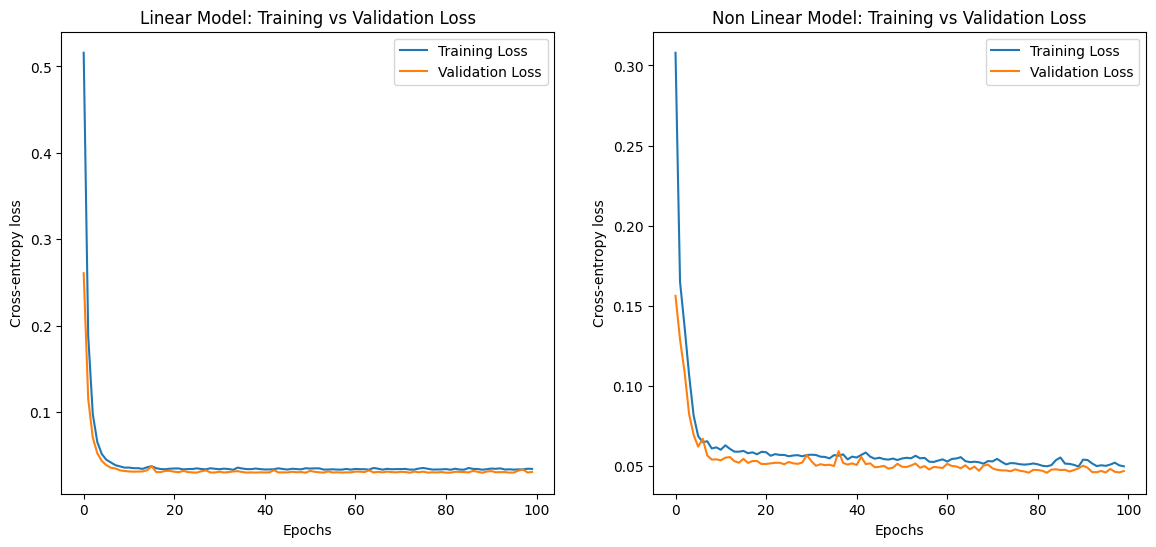

In [20]:
def plot_performance(title, history):
  plt.title(f'{title}: Training vs Validation Loss')
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.ylabel('Cross-entropy loss')
  plt.xlabel('Epochs')
  plt.legend()

# Training Performance
plt.figure(figsize=(14, 6))


# Plot cross-entropy for linear data
plt.subplot(1, 2, 1)
plot_performance('Linear Model', history1_linear)

# Plot cross-entropy for non-linear data
plt.subplot(1, 2, 2)
plot_performance('Non Linear Model', history2_nonlinear)

plt.show()

In [21]:
# Compute cross-entropy loss for the training set
train_loss_nn1_linear = neural_network_linear.evaluate(training_set_x, training_set_y1, verbose=1)
train_loss_nn2_nonlinear = neural_network_nonlinear.evaluate(training_set_x, training_set_y2, verbose=1)

# Compute cross-entropy loss for the test set
test_loss_nn1_linear = neural_network_linear.evaluate(test_set_x, test_set_y1, verbose=1)
test_loss_nn2_nonlinear = neural_network_nonlinear.evaluate(test_set_x, test_set_y2, verbose=1)

predicted_nn_y1 = neural_network_linear.predict(test_set_x)
predicted_nn_y2 = neural_network_nonlinear.predict(test_set_x)

print(f"Training Loss for neural network 1 linear: {train_loss_nn1_linear:.3f}")
print(f"Test Loss for neural network 1 linear: {test_loss_nn1_linear:.3f}")

print(f"Training Loss for neural network 2 non linear: {train_loss_nn2_nonlinear:.3f}")
print(f"Test Loss for neural network 2 non linear: {test_loss_nn2_nonlinear:.3f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0333
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0485
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0331
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0492
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Training Loss for neural network 1 linear: 0.033
Test Loss for neural network 1 linear: 0.035
Training Loss for neural network 2 non linear: 0.049
Test Loss for neural network 2 non linear: 0.046


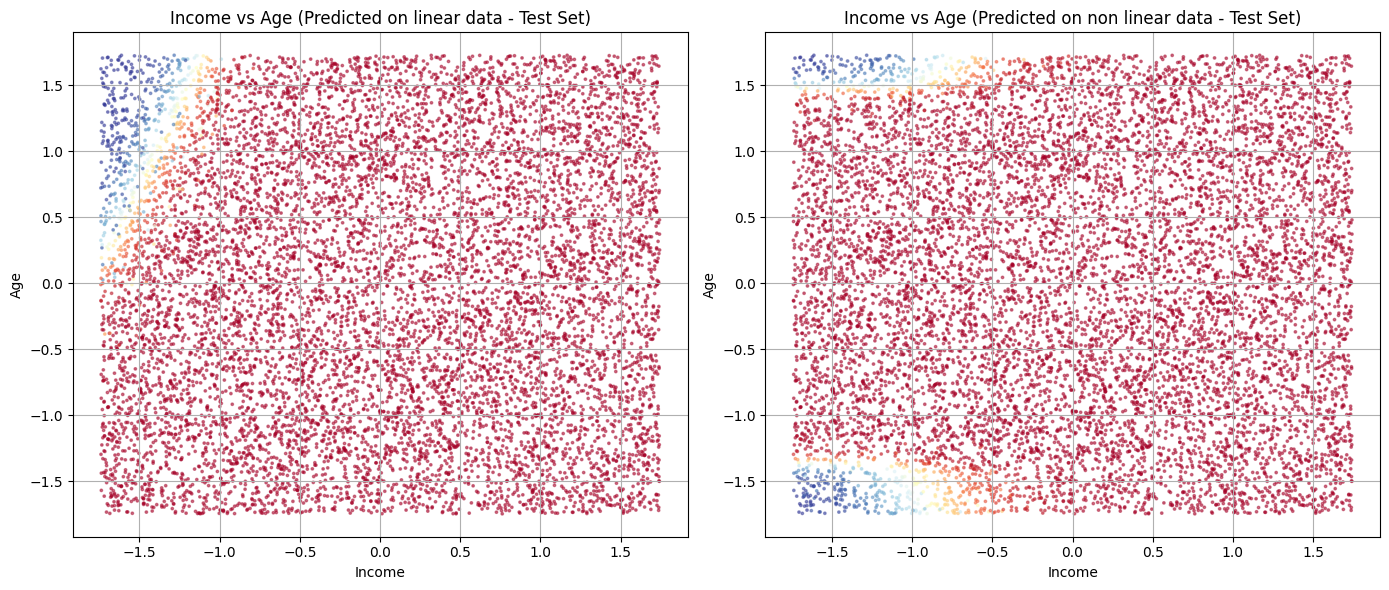

In [22]:
plt.figure(figsize=(14, 6))

# Scatter plot for predicted_y1
plt.subplot(1, 2, 1)
plt.scatter(test_set_x[:, 1], test_set_x[:, 0], c=predicted_nn_y1, cmap=plt.cm.RdYlBu, alpha=0.5, s=3)
plt.title('Income vs Age (Predicted on linear data - Test Set)')
plt.xlabel('Income')
plt.ylabel('Age')
plt.grid(True)

# Scatter plot for predicted_y2( really bad!)
plt.subplot(1, 2, 2)
plt.scatter(test_set_x[:, 1], test_set_x[:, 0], c=predicted_nn_y2, cmap=plt.cm.RdYlBu, alpha=0.5, s=3)
plt.title('Income vs Age (Predicted on non linear data - Test Set)')
plt.xlabel('Income')
plt.ylabel('Age')
plt.grid(True)

plt.tight_layout()
plt.show()

#### Hyperparameter Tuning with normal loss function

In [23]:
import tensorflow as tf
import keras_tuner as kt
from sklearn.model_selection import KFold


class HyperModelTuned(kt.HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(keras.layers.Input(shape=(3,)))

        # Activation function
        hp_activation_fnc = hp.Choice('activation_type', values=['relu', 'leaky_relu'])

        # Tune the number of layers
        for i in range(hp.Int('num_layers', 2, 5)): #number of layers
            model.add(keras.layers.Dense(
                units=hp.Int(f'units_layer_{i}', min_value=18, max_value=50, step=2),
                activation=None, #activation function set to none to perform batch normalization
                bias_initializer='zeros',
                kernel_initializer="he_normal")) # Weight initialization along with ReLU
            model.add(keras.layers.BatchNormalization()) # batch normalization after each Dense layer

            # Activation function
            if hp_activation_fnc == 'relu':
                model.add(keras.layers.ReLU())
            else:
                model.add(keras.layers.LeakyReLU(negative_slope=0.2))

        model.add(keras.layers.Dense(1, activation='sigmoid')) # output layer

        hp_learning_rate = hp.Choice('learning_rate',
                                    values=[1e-2, 1e-3, 1e-4]
                                    )
        optimizers_dict = {
            "Adam":    keras.optimizers.Adam(learning_rate=hp_learning_rate),
            "RMSprop":     keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
            }


        hp_optimizers = hp.Choice(
            'optimizer',
            values=["Adam", "RMSprop"]
            )

        model.compile(
            loss=keras.losses.BinaryCrossentropy(),
            optimizer=optimizers_dict[hp_optimizers],
            metrics=['recall'])
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32, 64, 128]),
            **kwargs,
        )


def tuner_build_model_cv(training_set_x, training_set_y, path, name, e, random_seed, k=5):
    kfold = KFold(n_splits=k, shuffle=True, random_state=random_seed)
    all_val_losses = []

    # Save the best tuner from all folds
    best_tuner = None
    best_loss = float('inf')

    fold = 1
    for train_index, val_index in kfold.split(training_set_x):
        print(f"\n--- Fold {fold} ---")

        x_train, x_val = training_set_x[train_index], training_set_x[val_index]
        y_train, y_val = training_set_y[train_index], training_set_y[val_index]

        tuner = kt.RandomSearch(
            HyperModelTuned(),
            objective='val_loss',
            max_trials=10,
            executions_per_trial=1,
            seed=random_seed,
            directory=path,
            project_name=f"{name}_fold{fold}"
        )

        stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
        tuner.search(x_train, y_train, epochs=e, validation_data=(x_val, y_val), callbacks=[stop_early])

        best_hp = tuner.get_best_hyperparameters(1)[0]
        best_model = tuner.hypermodel.build(best_hp)
        best_model.fit(x_train, y_train, epochs=e, validation_split=0.2, callbacks=[stop_early])

        val_loss = best_model.evaluate(x_val, y_val, verbose=0)[0]
        all_val_losses.append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_tuner = tuner

        fold += 1

    print(f"\nAverage validation loss over {k} folds: {np.mean(all_val_losses)}")
    return best_tuner

# Get the optimal hyperparameters
tuner_nonlinear_noLossCustomization = tuner_build_model_cv(training_set_x, training_set_y2, 'tuner', 'model_FinalTuned', random_seed=random_seed, e=epochs)


--- Fold 1 ---
Reloading Tuner from tuner/model_FinalTuned_fold1/tuner0.json
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.3874 - recall: 0.2359 - val_loss: 0.2461 - val_recall: 0.6222
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2340 - recall: 0.4895 - val_loss: 0.1639 - val_recall: 0.6667
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1752 - recall: 0.4292 - val_loss: 0.1284 - val_recall: 0.6815
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1445 - recall: 0.3964 - val_loss: 0.1030 - val_recall: 0.6667
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1193 - recall: 0.4069 - val_loss: 0.0926 - val_recall: 0.7630
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1129 - recall: 0.4499 - val_loss: 0.0877 - val_recall: 0.7852
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1072 - recall: 0.4345 - val_loss: 0.0793 - val_recall: 0.7481
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms

In [24]:
best_batch_size = tuner_nonlinear_noLossCustomization.get_best_hyperparameters(1)[0].get('batch_size')
print(f"Best batch size: {best_batch_size}")

best_NN_nonlinear_cv = tuner_nonlinear_noLossCustomization.hypermodel.build(tuner_nonlinear_noLossCustomization.get_best_hyperparameters(num_trials = 1)[0])
stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=80)
history_nonlinear_cv = best_NN_nonlinear_cv.fit(x=training_set_x, y=training_set_y2, batch_size=best_batch_size, epochs=500, validation_split=0.2, callbacks=[stop], verbose = 0)

Best batch size: 64


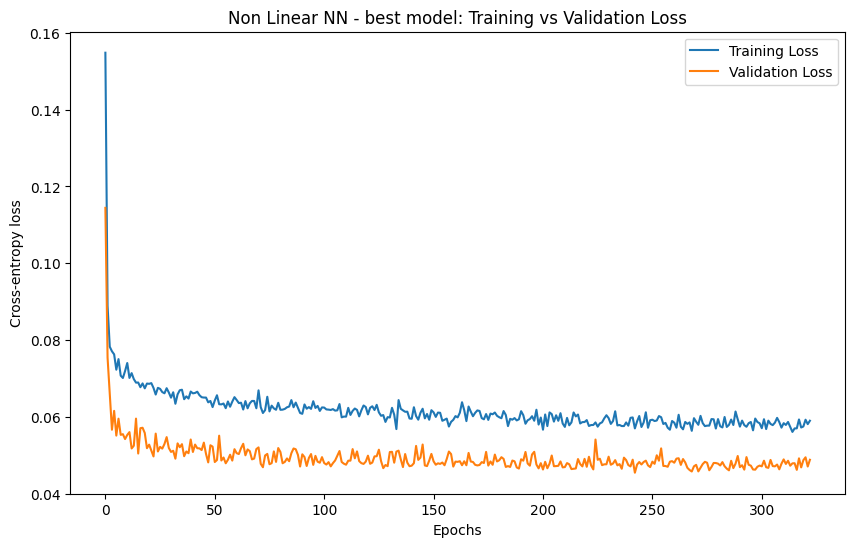

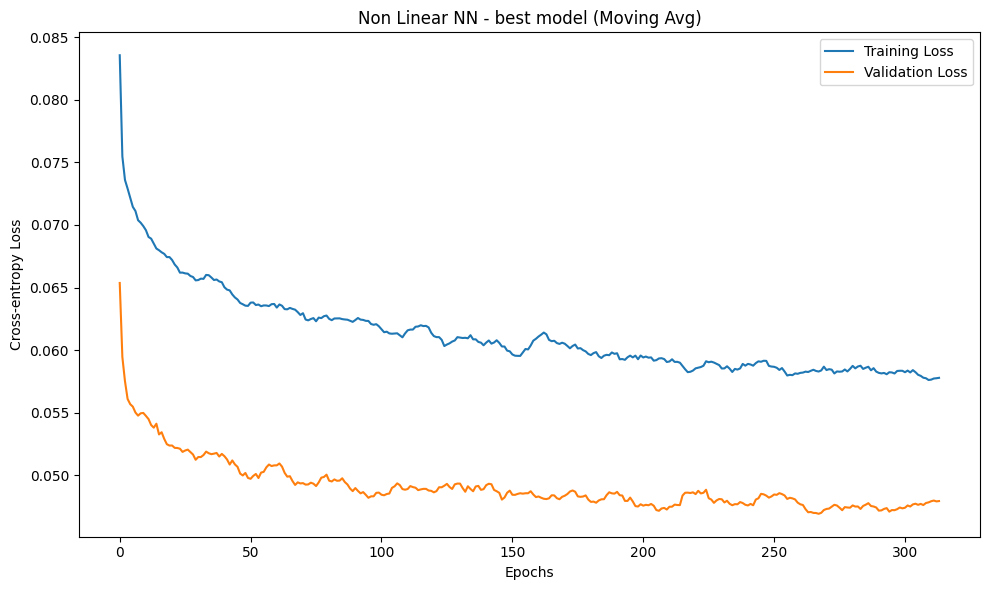

In [25]:
# Plot cross-entropy for best tuner
plt.figure(figsize=(10, 6))
plot_performance('Non Linear NN - best model', history_nonlinear_cv)
plt.show()

def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Extract losses
train_loss = history_nonlinear_cv.history['loss']
val_loss = history_nonlinear_cv.history.get('val_loss', [])

# Compute moving averages
window_size = 10
ma_train_loss = moving_average(train_loss, window_size)
ma_val_loss = moving_average(val_loss, window_size) if val_loss else []

# Plot
plt.figure(figsize=(10, 6))
plt.title(f'Non Linear NN - best model (Moving Avg)')
plt.plot(ma_train_loss, label='Training Loss')
if val_loss:
    plt.plot(ma_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-entropy Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
from tensorflow.keras.utils import plot_model

# Generate both a plot and a text description
plot_model(best_NN_nonlinear_cv, show_shapes=True, show_layer_names=True,
    dpi=96  # adjust for higher resolution if needed
)


You must install pydot (`pip install pydot`) for `plot_model` to work.


In [27]:
# Get the best hyperparameters from the tuner
best_hps = tuner_nonlinear_noLossCustomization.get_best_hyperparameters(1)[0]

# Print all the hyperparameters
print("Best hyperparameters:")
for hp_name in best_hps.values.keys():
    print(f"{hp_name}: {best_hps.get(hp_name)}")

best_NN_nonlinear_cv.summary()

Best hyperparameters:
activation_type: relu
num_layers: 3
units_layer_0: 42
units_layer_1: 32
learning_rate: 0.001
optimizer: Adam
batch_size: 64
units_layer_2: 34
units_layer_3: 24
units_layer_4: 26


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_34 (Dense)                │ (None, 42)             │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 42)             │           168 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_23 (ReLU)                 │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 32)             │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_24 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 34)             │         1,122 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 34)             │           136 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_25 (ReLU)                 │ (None, 34)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            35 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,969 (35.04 KB)

 Trainable params: 2,917 (11.39 KB)

 Non-trainable params: 216 (864.00 B)

 Optimizer params: 5,836 (22.80 KB)

#### Customized Loss Function

In [28]:
# Customize loss function
def binary_cost_sensitive_loss(y_true, y_pred):
    # Avoid log(0) by clipping predicted probabilities
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

    # For true positives (y==1): weight the negative log likelihood by 100.
    loss_pos = -100.0 * y_true * tf.math.log(y_pred)

    # For negatives (y==0): use the negative log likelihood; then subtract the profit (1)
    loss_neg = -(1.0 - y_true) * (tf.math.log(1.0 - y_pred) + 1.0)

    # Sum the losses and take the average over the batch.
    loss = loss_pos + loss_neg
    return tf.reduce_mean(loss)

In [29]:
def NeuralNetworkCustomized(lr, width):
  """
  This function creates a neural network, depending on the given parameters:
  - units: number of neurons in the hidden layers
  - lr: learning rate
  - hl_number: number of hidden layers
  - Adds batch normalization after each dense hidden layer.
  """

  model = keras.Sequential()
  model.add(keras.Input(shape=(3,)))

  for units in width:
    model.add(keras.layers.Dense(units,
                               activation=None,
                                 bias_initializer='zeros',
                                 kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
  model.add(keras.layers.Dense(1, activation='sigmoid'))
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                loss=binary_cost_sensitive_loss,
                metrics=['accuracy', 'recall'])
  return model

tuned_lr = best_hps.get('learning_rate')
tuned_B = best_hps.get('batch_size')
tuned_depth = best_hps.get('num_layers')
tuned_width = [best_hps.get(f'units_layer_{i}') for i in range(tuned_depth)]


In [30]:
neural_network_customized = NeuralNetworkCustomized(lr=tuned_lr, width=tuned_width)
history_nonlinear = neural_network_customized.fit(x=training_set_x, y=training_set_y2, batch_size=tuned_B, epochs=500, validation_split=0.2, callbacks=[stop])

Epoch 1/500
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6699 - loss: 0.5801 - recall: 0.9409 - val_accuracy: 0.7515 - val_loss: -0.1709 - val_recall: 0.9879
Epoch 2/500
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8092 - loss: -0.1992 - recall: 0.9894 - val_accuracy: 0.8295 - val_loss: -0.3680 - val_recall: 0.9879
Epoch 3/500
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8301 - loss: -0.2061 - recall: 0.9806 - val_accuracy: 0.8415 - val_loss: -0.4396 - val_recall: 0.9939
Epoch 4/500
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8559 - loss: -0.3768 - recall: 0.9960 - val_accuracy: 0.8052 - val_loss: -0.3461 - val_recall: 0.9879
Epoch 5/500
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8425 - loss: -0.3452 - recall: 0.9944 - val_accuracy: 0.8620 - val_loss: -0.4601 - val_recall: 0.9879
Epoch 6/500
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8584 - loss: -0.3359 - recall: 0.9855 - val_accuracy: 0.8570 - val_loss: -0.4695 - val_re

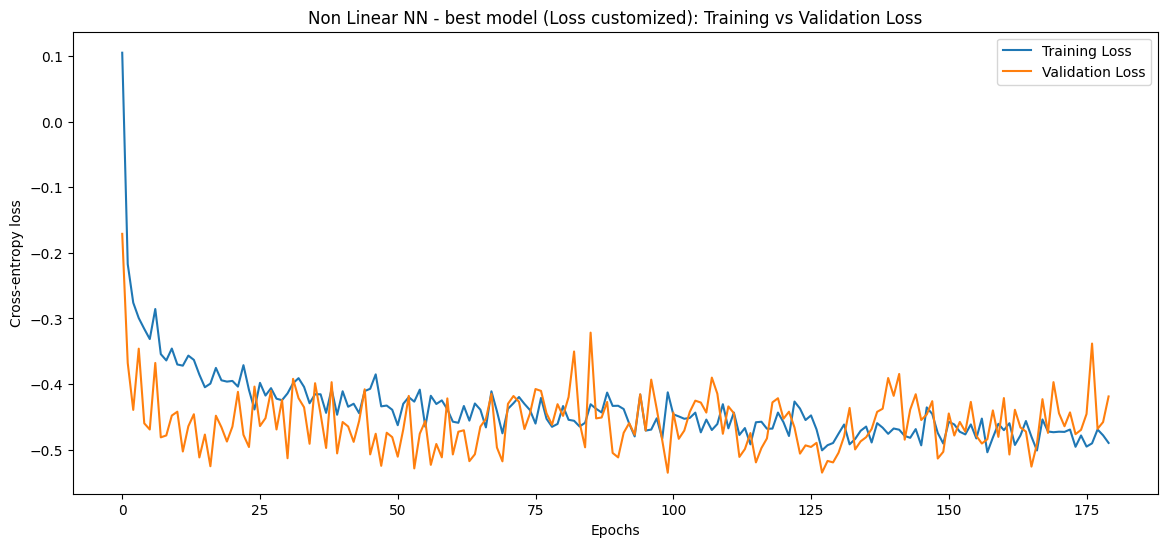

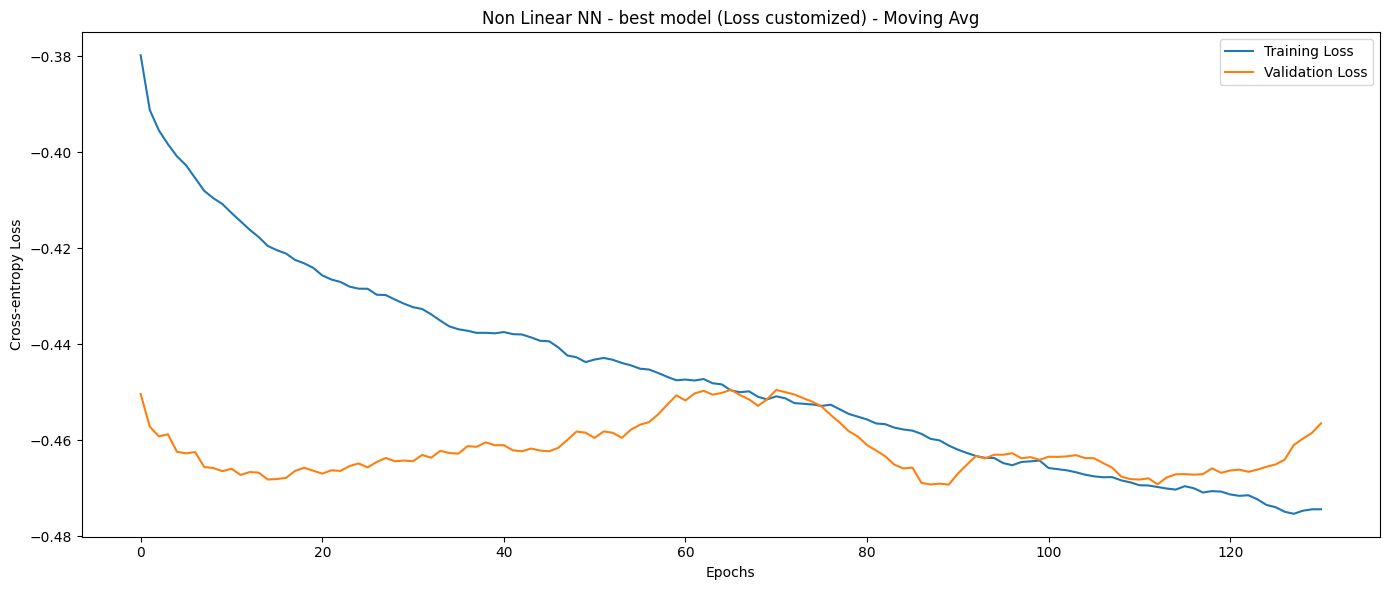

In [31]:
# Plot cross-entropy for linear data
plt.figure(figsize=(14, 6))
plot_performance('Non Linear NN - best model (Loss customized)', history_nonlinear)
plt.show()

# Extract losses
train_loss_customized = history_nonlinear.history['loss']
val_loss_customized = history_nonlinear.history.get('val_loss', [])

# Compute moving averages
window_size = 50
ma_train_loss_customized = moving_average(train_loss_customized, window_size)
ma_val_loss_customized = moving_average(val_loss_customized, window_size) if val_loss else []

# Plot
plt.figure(figsize=(14, 6))
plt.title(f'Non Linear NN - best model (Loss customized) - Moving Avg')
plt.plot(ma_train_loss_customized, label='Training Loss')
if val_loss:
    plt.plot(ma_val_loss_customized, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-entropy Loss')
plt.legend()
plt.tight_layout()
plt.show()


In [32]:
# Compute cross-entropy loss for the test set
test_loss_nn2 = neural_network_customized.evaluate(test_set_x, test_set_y2, verbose=1)

print(f"Test Loss for neural network non linear: {test_loss_nn2}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8912 - loss: -0.3416 - recall: 0.9855
Test Loss for neural network non linear: [-0.45715853571891785, 0.8847000002861023, 0.9956616163253784]


### 3c) ROC curves and AUC scores

In [33]:
# Get predictions for all models
# Linear data models
logistic_linear_test_pred = logistic_regression_linear.predict_proba(test_set_x)[:, 1]
neural_linear_test_pred = neural_network_linear.predict(test_set_x)

# Non-linear data models
logistic_nonlinear_test_pred = logistic_regression_nonlinear.predict_proba(test_set_x)[:, 1]

# Benchmark NN
NN_benchmark = neural_network_nonlinear.predict(test_set_x)
print(classification_report(test_set_y2, np.round(NN_benchmark), digits=3))

# NN fine-tuned
NN_tuned = best_NN_nonlinear_cv.predict(test_set_x)
print(classification_report(test_set_y2, np.round(NN_tuned), digits=3))
print(metrics.confusion_matrix(test_set_y2, np.round(NN_tuned)))

# NN with customized Loss
NN_customized = neural_network_customized.predict(test_set_x)
print(classification_report(test_set_y2, np.round(NN_customized), digits=3))
print(metrics.confusion_matrix(test_set_y2, np.round(NN_customized)))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0      0.987     0.993     0.990      9539
           1      0.837     0.725     0.777       461

    accuracy                          0.981     10000
   macro avg      0.912     0.859     0.883     10000
weighted avg      0.980     0.981     0.980     10000

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0      0.987     0.993     0.990      9539
           1      0.829     0.727     0.775       461

    accuracy                          0.981     10000
   macro avg      0.908     0.860     0.882     10000
weighted avg      0.980     0.981     0.980     10000

[[9470   69]
 [ 126  335]]
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0      1.000     0.879     0.936      9539
           1      0.285     0.996     0.443   

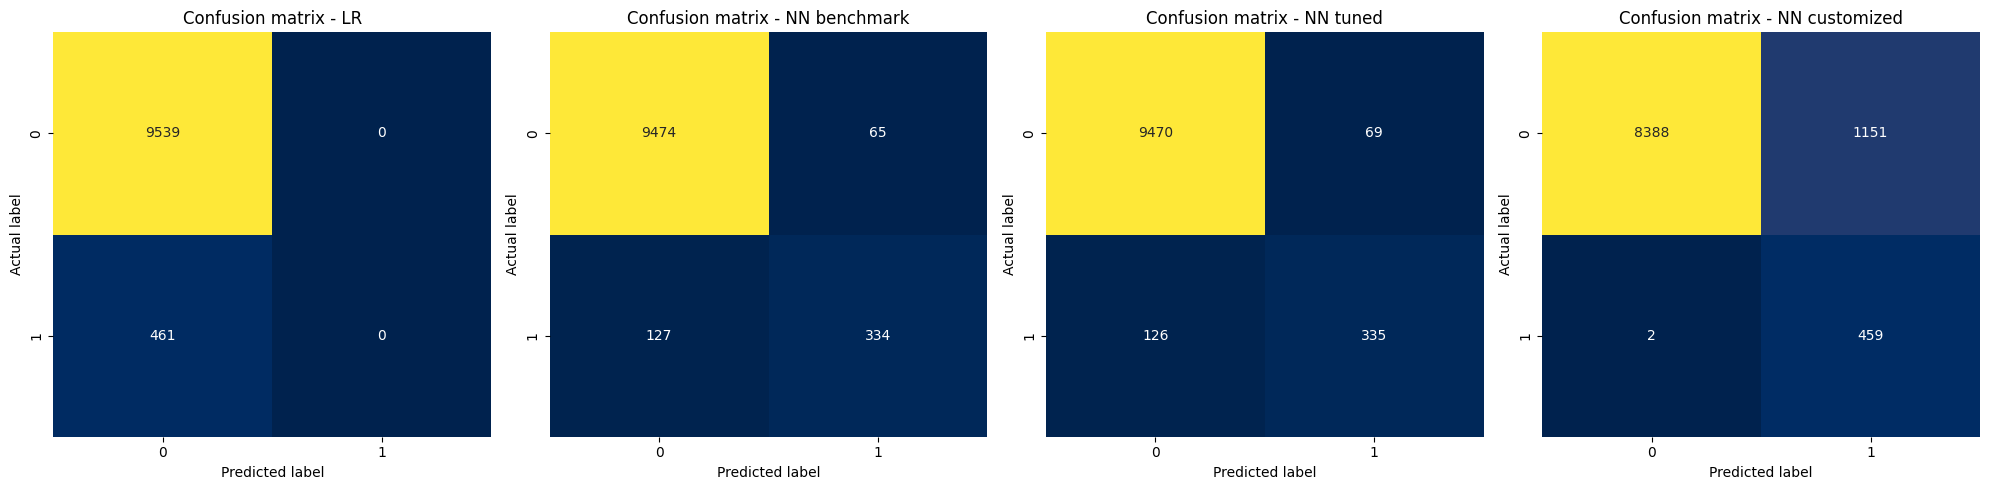

In [34]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
class_names = ["0", "1"]

# Helper function for plotting each confusion matrix
def plot_conf_matrix(ax, cm, title):
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="cividis", fmt='g', cbar=False, ax=ax)
    ax.set_xticks([0.5, 1.5])
    ax.set_yticks([0.5, 1.5])
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    ax.set_ylabel('Actual label')
    ax.set_xlabel('Predicted label')
    ax.set_title(title)

# Confusion matrices
cm1 = metrics.confusion_matrix(test_set_y2, predicted_y2)
cm2 = metrics.confusion_matrix(test_set_y2, np.round(NN_benchmark))
cm3 = metrics.confusion_matrix(test_set_y2, np.round(NN_tuned))
cm4 = metrics.confusion_matrix(test_set_y2, np.round(NN_customized))

# Plot each
plot_conf_matrix(axes[0], cm1, 'Confusion matrix - LR')
plot_conf_matrix(axes[1], cm2, 'Confusion matrix - NN benchmark')
plot_conf_matrix(axes[2], cm3, 'Confusion matrix - NN tuned')
plot_conf_matrix(axes[3], cm4, 'Confusion matrix - NN customized')

plt.tight_layout()
plt.show()

In [35]:
# Compute ROC curves and AUC scores
# Linear data comparison
fpr_logistic_linear, tpr_logistic_linear, _ = roc_curve(test_set_y1, logistic_linear_test_pred)
auc_logistic_linear = roc_auc_score(test_set_y1, logistic_linear_test_pred)

fpr_neural_linear, tpr_neural_linear, _ = roc_curve(test_set_y1, neural_linear_test_pred)
auc_neural_linear = roc_auc_score(test_set_y1, neural_linear_test_pred)

# Non-linear data comparison
fpr_logistic_nonlinear, tpr_logistic_nonlinear, _ = roc_curve(test_set_y2, logistic_nonlinear_test_pred)
auc_logistic_nonlinear = roc_auc_score(test_set_y2, logistic_nonlinear_test_pred)

fpr_NN_benchmark, tpr_NN_benchmark, _ = roc_curve(test_set_y2, NN_benchmark)
auc_NN_benchmark = roc_auc_score(test_set_y2, NN_benchmark)

fpr_NN_tuned, tpr_NN_tuned, _ = roc_curve(test_set_y2, NN_tuned)
auc_NN_tuned = roc_auc_score(test_set_y2, NN_tuned)

fpr_NN_customized, tpr_NN_customized, _ = roc_curve(test_set_y2, NN_customized)
auc_NN_customized = roc_auc_score(test_set_y2, NN_customized)


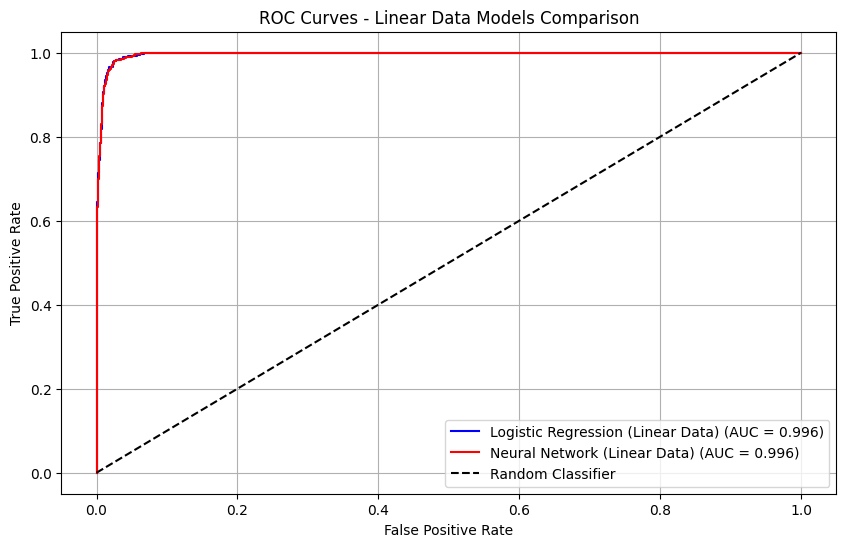

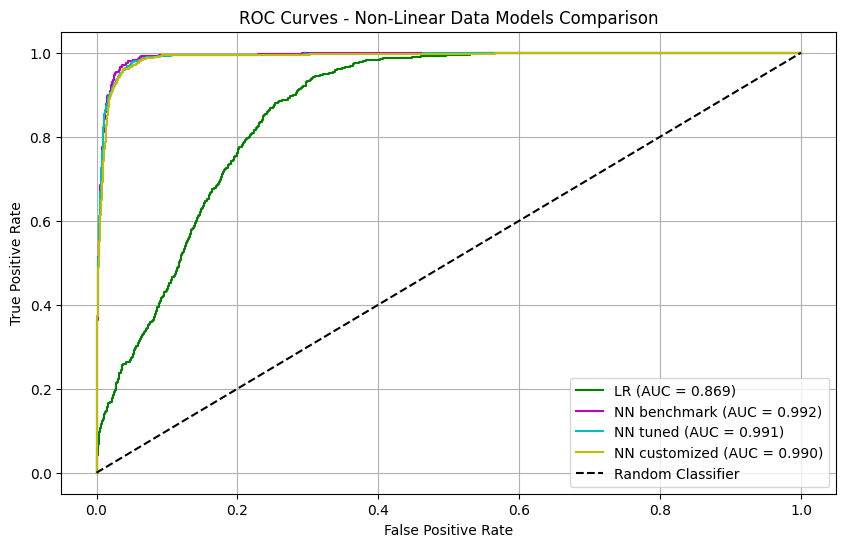

Linear Data Comparison:
Logistic Regression AUC: 0.996
Neural Network AUC: 0.996

Non-Linear Data Comparison:
Logistic Regression AUC: 0.869
Neural Network AUC: 0.992
Neural Network AUC: 0.991
Neural Network AUC: 0.990


In [36]:
# Plot ROC curves for linear data comparison
plt.figure(figsize=(10, 6))
plt.plot(fpr_logistic_linear, tpr_logistic_linear, 'b-', label=f'Logistic Regression (Linear Data) (AUC = {auc_logistic_linear:.3f})')
plt.plot(fpr_neural_linear, tpr_neural_linear, 'r-', label=f'Neural Network (Linear Data) (AUC = {auc_neural_linear:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Linear Data Models Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot ROC curves for non-linear data comparison
plt.figure(figsize=(10, 6))
plt.plot(fpr_logistic_nonlinear, tpr_logistic_nonlinear, 'g-', label=f'LR (AUC = {auc_logistic_nonlinear:.3f})')
plt.plot(fpr_NN_benchmark, tpr_NN_benchmark, 'm-', label=f'NN benchmark (AUC = {auc_NN_benchmark:.3f})')
plt.plot(fpr_NN_tuned, tpr_NN_tuned, 'c-', label=f'NN tuned (AUC = {auc_NN_tuned:.3f})')
plt.plot(fpr_NN_customized, tpr_NN_customized, 'y-', label=f'NN customized (AUC = {auc_NN_customized:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Non-Linear Data Models Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print AUC scores
print("Linear Data Comparison:")
print(f"Logistic Regression AUC: {auc_logistic_linear:.3f}")
print(f"Neural Network AUC: {auc_neural_linear:.3f}")
print("\nNon-Linear Data Comparison:")
print(f"Logistic Regression AUC: {auc_logistic_nonlinear:.3f}")
print(f"Neural Network AUC: {auc_NN_benchmark:.3f}")
print(f"Neural Network AUC: {auc_NN_tuned:.3f}")
print(f"Neural Network AUC: {auc_NN_customized:.3f}")

# Exercise 4. Comparison of lending strategies

In [37]:
lr2_pred_test = logistic_regression_nonlinear.predict_proba(test_set_x)[:,1]
nn1_pred_test = neural_network_nonlinear.predict(test_set_x).flatten()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
# 4. Lending Strategy Simulation
interest_all = 0.055
interest_sel = 0.010

# Simulate 1000 market scenarios
D = np.random.binomial(1,p2[m:, np.newaxis], size=(n, 1000))

# Strategies (per borrower)
def strategy_per_borrower(d_matrix, selected_indices, interest):
    loan_amount = 100
    repayments = loan_amount * (1 + interest)
    profit_matrix = np.where(d_matrix == 0, repayments, 0) - loan_amount
    return profit_matrix[selected_indices].mean(axis=0)

def strategy_total_profit(default_matrix, selected_indices, interest):
    """
    Calculate total profit for a given strategy.
    Parameters:
    default_matrix (np.ndarray): Matrix of defaults for each borrower.
    selected_indices (list): Indices of selected borrowers.
    interest (float): Interest rate for the selected borrowers.

    Returns:
    np.ndarray: Total profit for the selected borrowers.
    """

    loan_amount = 100
    # Calculate repayments and profit matrix
    repayments = loan_amount * (1 + interest)
    profit_matrix = np.where(default_matrix == 0, repayments, 0) - loan_amount
    return profit_matrix[selected_indices].sum(axis=0)

# Strategy (i): All borrowers
profit_i = strategy_per_borrower(D, np.arange(n), interest_all)
profit_i_mean = profit_i.mean(axis=0)

# Strategy (ii): Logistic Regression (threshold=0.05)
selected_lr = np.where(lr2_pred_test <= 0.05)[0]
profit_lr = strategy_per_borrower(D, selected_lr, interest_sel)
profit_lr_mean = profit_lr.mean(axis=0)

# Strategy (iii): Neural Network (threshold=0.05)
selected_nn = np.where(nn1_pred_test <= 0.05)[0]
profit_nn = strategy_per_borrower(D, selected_nn, interest_sel)
profit_nn_mean = profit_nn.mean(axis=0)

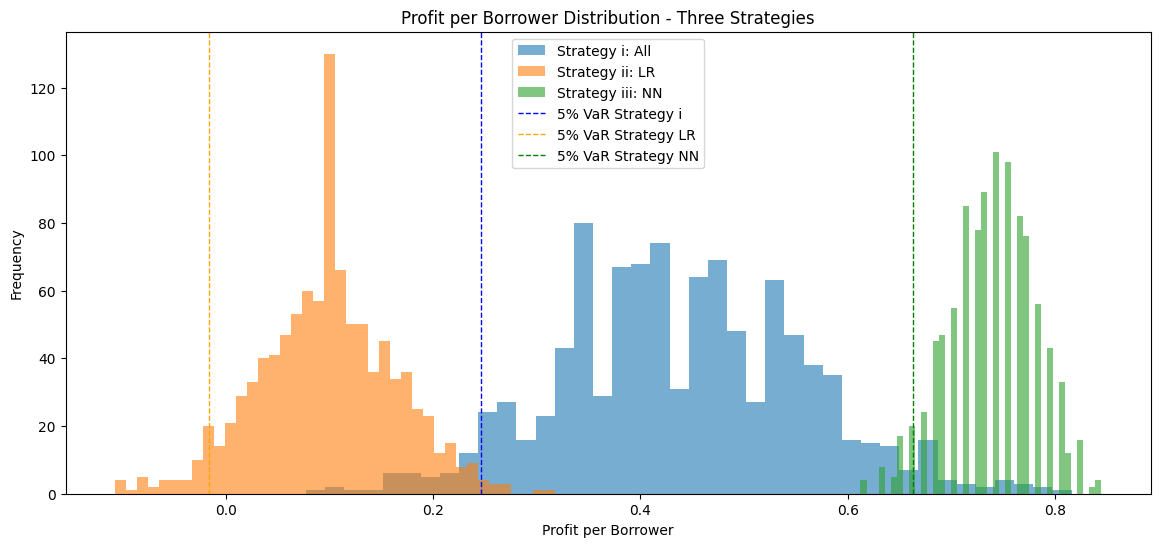

Mean Profit Strategy i: 0.439
Mean Profit Strategy LR: 0.098
Mean Profit Strategy NN: 0.738
5% VaR Strategy i: 0.246
5% VaR Strategy LR: -0.016
5% VaR Strategy NN: 0.663


In [79]:
# 5. Results and Visualization
plt.figure(figsize=(14, 6))
# Plot histograms of the three strategies
plt.hist(profit_i, bins=40, alpha=0.6, label='Strategy i: All')
plt.hist(profit_lr, bins=40, alpha=0.6, label='Strategy ii: LR')
plt.hist(profit_nn, bins=40, alpha=0.6, label='Strategy iii: NN')

plt.xlabel('Profit per Borrower')
plt.axvline(np.percentile(profit_i, 5), color='blue', linestyle='dashed', linewidth=1, label='5% VaR Strategy i')
plt.axvline(np.percentile(profit_lr, 5), color='orange', linestyle='dashed', linewidth=1, label='5% VaR Strategy LR')
plt.axvline(np.percentile(profit_nn, 5), color='green', linestyle='dashed', linewidth=1, label='5% VaR Strategy NN')
plt.ylabel('Frequency')
plt.legend()
plt.title('Profit per Borrower Distribution - Three Strategies')
plt.show()
#print the mean profit for each strategy
print(f'Mean Profit Strategy i: {profit_i_mean:.3f}')
print(f'Mean Profit Strategy LR: {profit_lr_mean:.3f}')
print(f'Mean Profit Strategy NN: {profit_nn_mean:.3f}')
# Calculate VaR per borrower for the three strategies
print(f'5% VaR Strategy i: {np.percentile(profit_i, 5):.3f}')
print(f'5% VaR Strategy LR: {np.percentile(profit_lr, 5):.3f}')
print(f'5% VaR Strategy NN: {np.percentile(profit_nn, 5):.3f}')

In [ ]:
nn2_pred_test = best_NN_nonlinear_cv.predict(test_set_x).flatten()

# Strategy (iii): Neural Network (threshold=0.05) tuned
selected_2nn = np.where(nn2_pred_test <= 0.05)[0]
profit_2nn = strategy_per_borrower(D, selected_2nn, interest_sel)
profit_2nn_mean = profit_2nn.mean(axis=0)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


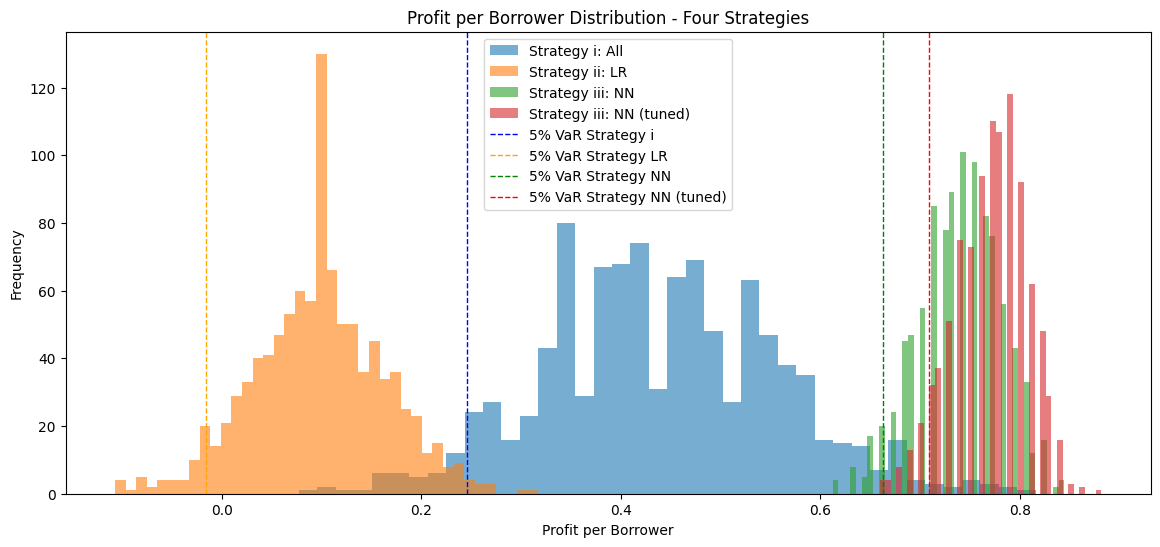

Mean Profit Strategy i: 0.439
Mean Profit Strategy LR: 0.098
Mean Profit Strategy NN: 0.738
Mean Profit Strategy NN (tuned): 0.770
5% VaR Strategy i: 0.246
5% VaR Strategy LR: -0.016
5% VaR Strategy NN: 0.663
5% VaR Strategy NN (tuned): 0.709


In [81]:
plt.figure(figsize=(14, 6))
# Plot histograms of the three strategies
plt.hist(profit_i, bins=40, alpha=0.6, label='Strategy i: All')
plt.hist(profit_lr, bins=40, alpha=0.6, label='Strategy ii: LR')
plt.hist(profit_nn, bins=40, alpha=0.6, label='Strategy iii: NN')
plt.hist(profit_2nn, bins=40, alpha=0.6, label='Strategy iii: NN (tuned)')

plt.xlabel('Profit per Borrower')
plt.axvline(np.percentile(profit_i, 5), color='blue', linestyle='dashed', linewidth=1, label='5% VaR Strategy i')
plt.axvline(np.percentile(profit_lr, 5), color='orange', linestyle='dashed', linewidth=1, label='5% VaR Strategy LR')
plt.axvline(np.percentile(profit_nn, 5), color='green', linestyle='dashed', linewidth=1, label='5% VaR Strategy NN')
plt.axvline(np.percentile(profit_2nn, 5), color='red', linestyle='dashed', linewidth=1, label='5% VaR Strategy NN (tuned)')
plt.ylabel('Frequency')
plt.legend()
plt.title('Profit per Borrower Distribution - Four Strategies')
plt.show()
#print the mean profit for each strategy
print(f'Mean Profit Strategy i: {profit_i_mean:.3f}')
print(f'Mean Profit Strategy LR: {profit_lr_mean:.3f}')
print(f'Mean Profit Strategy NN: {profit_nn_mean:.3f}')
print(f'Mean Profit Strategy NN (tuned): {profit_2nn_mean:.3f}')
# Calculate VaR per borrower for the three strategies
print(f'5% VaR Strategy i: {np.percentile(profit_i, 5):.3f}')
print(f'5% VaR Strategy LR: {np.percentile(profit_lr, 5):.3f}')
print(f'5% VaR Strategy NN: {np.percentile(profit_nn, 5):.3f}')
print(f'5% VaR Strategy NN (tuned): {np.percentile(profit_2nn, 5):.3f}')

In [ ]:
nn3_pred_test = neural_network_customized.predict(test_set_x).flatten()

# Strategy (iii): Neural Network (threshold=0.05) - customized
selected_3nn= np.where(nn3_pred_test <= 0.05)[0]
profit_3nn = strategy_per_borrower(D, selected_3nn, interest_sel)
profit_3nn_mean = profit_3nn.mean(axis=0)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [93]:
n

10000

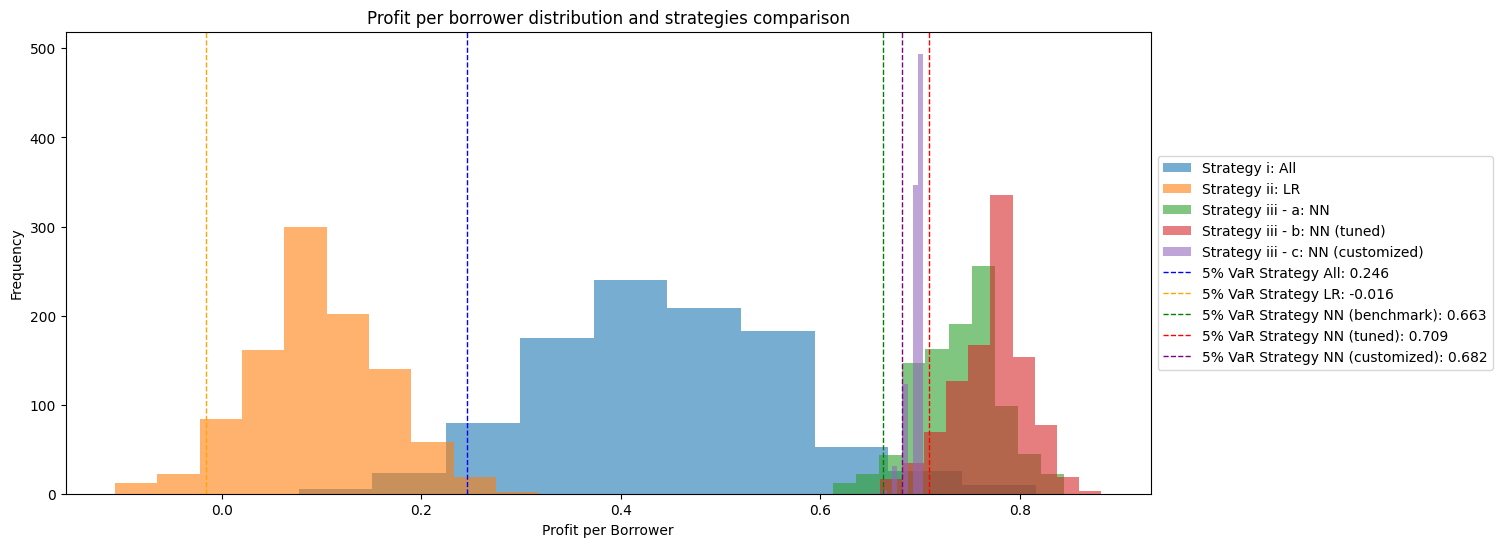

Mean Profit Strategy i: 0.439
Mean Profit Strategy LR: 0.098
Mean Profit Strategy NN: 0.738
Mean Profit Strategy NN (tuned): 0.770
Mean Profit Strategy NN (customized): 0.695
5% VaR Strategy All: 0.246
5% VaR Strategy LR: -0.016
5% VaR Strategy NN (benchmark): 0.663
5% VaR Strategy NN (tuned): 0.709
5% VaR Strategy NN (customized): 0.682


In [94]:
plt.figure(figsize=(14, 6))
# Plot histograms of the five strategies
plt.hist(profit_i, bins=10, alpha=0.6, label='Strategy i: All')
plt.hist(profit_lr, bins=10, alpha=0.6, label='Strategy ii: LR')
plt.hist(profit_nn, bins=10, alpha=0.6, label='Strategy iii - a: NN')
plt.hist(profit_2nn, bins=10, alpha=0.6, label='Strategy iii - b: NN (tuned)')
plt.hist(profit_3nn, bins=10, alpha=0.6, label='Strategy iii - c: NN (customized)')

plt.xlabel('Profit per Borrower')
plt.axvline(np.percentile(profit_i, 5), color='blue', linestyle='dashed', linewidth=1, label=f'5% VaR Strategy All: {np.percentile(profit_i, 5):.3f}')
plt.axvline(np.percentile(profit_lr, 5), color='orange', linestyle='dashed', linewidth=1, label=f'5% VaR Strategy LR: {np.percentile(profit_lr, 5):.3f}')
plt.axvline(np.percentile(profit_nn, 5), color='green', linestyle='dashed', linewidth=1, label=f'5% VaR Strategy NN (benchmark): {np.percentile(profit_nn, 5):.3f}')
plt.axvline(np.percentile(profit_2nn, 5), color='red', linestyle='dashed', linewidth=1, label=f'5% VaR Strategy NN (tuned): {np.percentile(profit_2nn, 5):.3f}')
plt.axvline(np.percentile(profit_3nn, 5), color='purple', linestyle='dashed', linewidth=1, label=f'5% VaR Strategy NN (customized): {np.percentile(profit_3nn, 5):.3f}')
plt.ylabel('Frequency')
plt.legend(bbox_to_anchor=(1.0, 0.5), loc='center left')

plt.title('Profit per borrower distribution and strategies comparison')
plt.show()

#print the mean profit for each strategy
print(f'Mean Profit Strategy i: {profit_i_mean:.3f}')
print(f'Mean Profit Strategy LR: {profit_lr_mean:.3f}')
print(f'Mean Profit Strategy NN: {profit_nn_mean:.3f}')
print(f'Mean Profit Strategy NN (tuned): {profit_2nn_mean:.3f}')
print(f'Mean Profit Strategy NN (customized): {profit_3nn_mean:.3f}')

# Calculate VaR per borrower for the three strategies
print(f'5% VaR Strategy All: {np.percentile(profit_i, 5):.3f}')
print(f'5% VaR Strategy LR: {np.percentile(profit_lr, 5):.3f}')
print(f'5% VaR Strategy NN (benchmark): {np.percentile(profit_nn, 5):.3f}')
print(f'5% VaR Strategy NN (tuned): {np.percentile(profit_2nn, 5):.3f}')
print(f'5% VaR Strategy NN (customized): {np.percentile(profit_3nn, 5):.3f}')

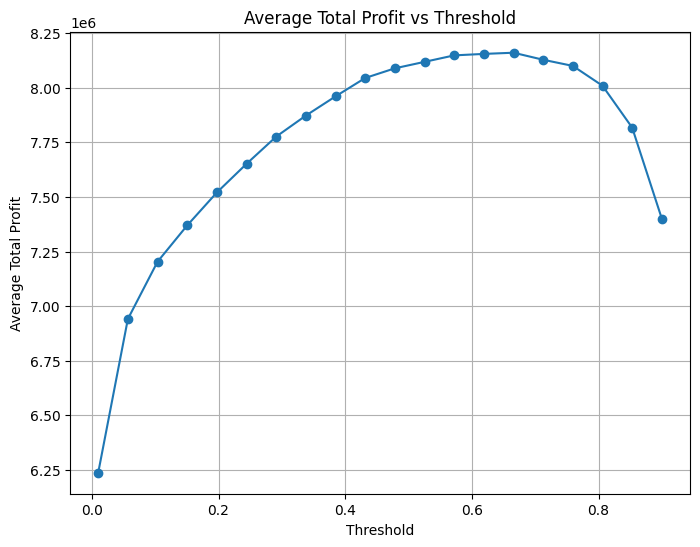

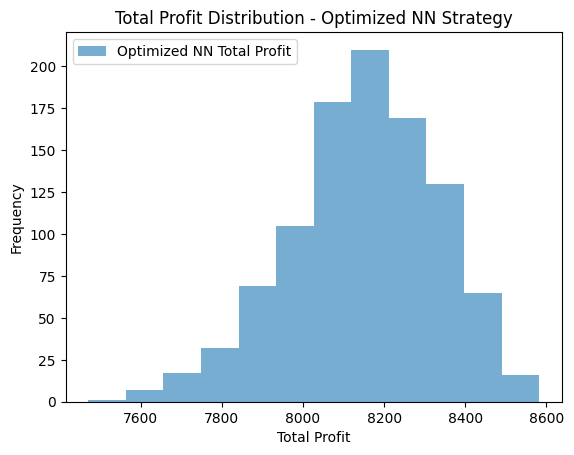

5% VaR Optimized NN Total Strategy: 7774.0
Optimal NN Average Profit: 8160.83
Optimal NN Threshold (Total PnL): 0.6657894736842105


In [87]:
# Optimal threshold selection maximizing total PnL
thresholds = np.linspace(0.01, 0.90, 20)
best_threshold, best_total_profit = 0, 0
total_profits_vs_threshold = []

for thresh in thresholds:
    selected_nn_thresh = np.where(nn3_pred_test <= thresh)[0]
    total_profit = strategy_total_profit(D, selected_nn_thresh, interest_sel).sum()
    total_profits_vs_threshold.append(total_profit)
    if total_profit > best_total_profit:
        best_total_profit = total_profit
        best_threshold = thresh

# Plot Total Profit vs Threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, total_profits_vs_threshold, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Average Total Profit')
plt.title('Average Total Profit vs Threshold')
plt.grid(True)
plt.show()

# Final optimal NN strategy based on total PnL
selected_nn_opt_total = np.where(nn3_pred_test <= best_threshold)[0]
total_profit_nn_opt = strategy_total_profit(D, selected_nn_opt_total, interest_sel)

# Plot histogram for optimized strategy (total profit)
plt.hist(total_profit_nn_opt, bins=12, alpha=0.6, label='Optimized NN Total Profit')
plt.xlabel('Total Profit')
plt.ylabel('Frequency')
plt.legend()
plt.title('Total Profit Distribution - Optimized NN Strategy')
plt.show()

# Calculate VaR for optimized total profit strategy
print('5% VaR Optimized NN Total Strategy:', np.percentile(total_profit_nn_opt, 5))
print('Optimal NN Average Profit:', total_profit_nn_opt.mean())
print('Optimal NN Threshold (Total PnL):', best_threshold)

Best Interest Rate: 0.1
Best Threshold: 0.01
Best PnL/Capital Ratio: 859.6315645139141


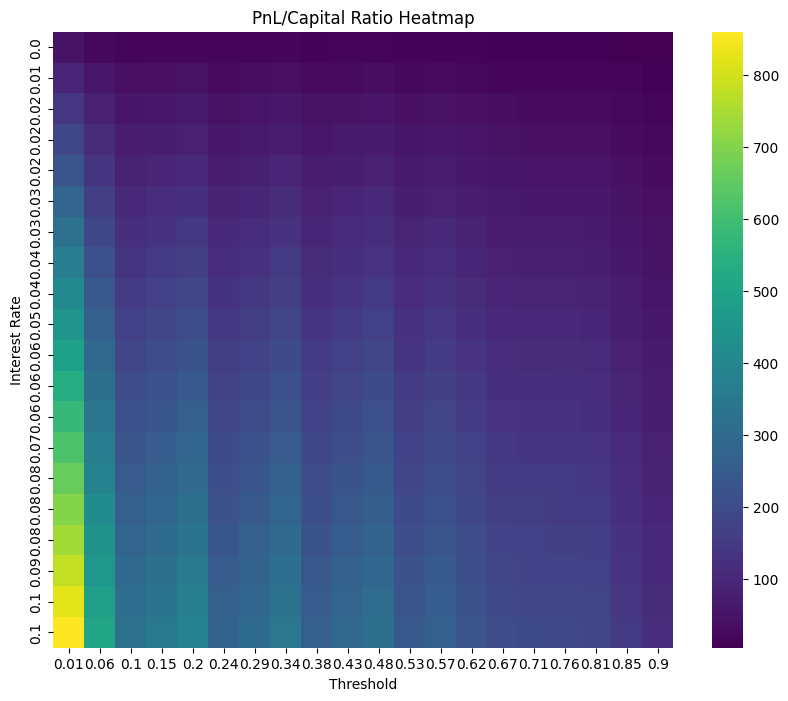

In [46]:
# Define ranges for interest rates and thresholds
interest_rates = np.linspace(0.005, 0.1, 20)  # Interest rates from 1% to 10%
thresholds = np.linspace(0.01, 0.9, 20)      # Thresholds from 0.01 to 0.2

best_interest, best_threshold = 0, 0
best_ratio = -np.inf

# Store results for visualization
results = []

for interest in interest_rates:
    for thresh in thresholds:
        # Select borrowers based on the threshold
        selected_nn_thresh = np.where(nn3_pred_test <= thresh)[0]

        # Calculate PnL and VaR
        total_profit = strategy_total_profit(D, selected_nn_thresh, interest).mean()
        VaR = np.percentile(strategy_total_profit(D, selected_nn_thresh, interest), 5)

        # Calculate capital and ratio
        capital = total_profit - VaR
        if capital > 0:  # Avoid division by zero or negative capital
            ratio = total_profit / capital
            results.append((interest, thresh, ratio))

            # Update the best parameters
            if ratio > best_ratio:
                best_ratio = ratio
                best_interest = interest
                best_threshold = thresh

# Print the best parameters and corresponding ratio
print('Best Interest Rate:', best_interest)
print('Best Threshold:', best_threshold)
print('Best PnL/Capital Ratio:', best_ratio)

# Visualize the results
ratios = np.array([r[2] for r in results]).reshape(len(interest_rates), len(thresholds))
plt.figure(figsize=(10, 8))
sns.heatmap(ratios, xticklabels=np.round(thresholds, 2), yticklabels=np.round(interest_rates, 2), annot=False, cmap='viridis')
plt.xlabel('Threshold')
plt.ylabel('Interest Rate')
plt.title('PnL/Capital Ratio Heatmap')
plt.show()

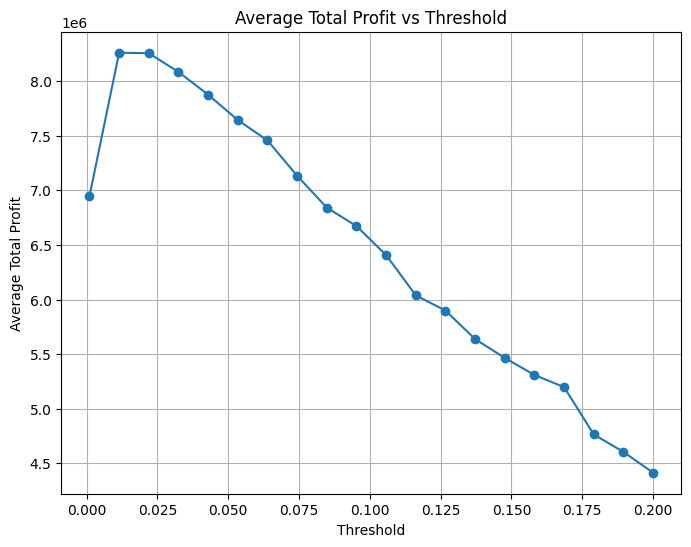

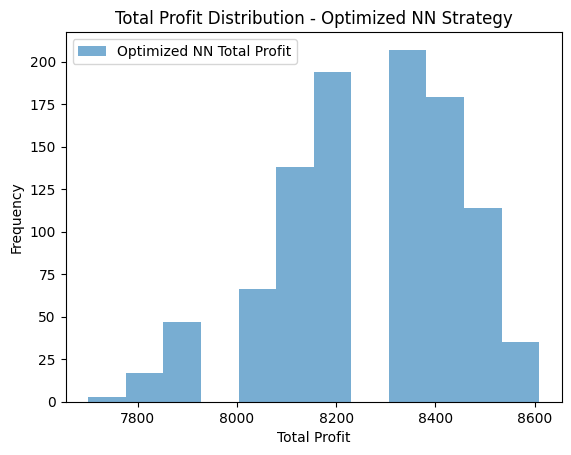

5% VaR Optimized NN Total Strategy: 7902.0
Optimal NN Average Profit: 8260.853
Optimal NN Threshold (Total PnL): 0.011473684210526316


In [98]:
# Optimal threshold selection maximizing total PnL
thresholds = np.linspace(0.001, 0.20, 20)
best_threshold, best_total_profit = 0, 0
total_profits_vs_threshold = []

for thresh in thresholds:
    selected_nn_thresh = np.where(nn2_pred_test <= thresh)[0]
    total_profit = strategy_total_profit(D, selected_nn_thresh, interest_sel).sum()
    total_profits_vs_threshold.append(total_profit)
    if total_profit > best_total_profit:
        best_total_profit = total_profit
        best_threshold = thresh

# Plot Total Profit vs Threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, total_profits_vs_threshold, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Average Total Profit')
plt.title('Average Total Profit vs Threshold')
plt.grid(True)
plt.show()

# Final optimal NN strategy based on total PnL
selected_nn_opt_total = np.where(nn2_pred_test <= best_threshold)[0]
total_profit_nn_opt = strategy_total_profit(D, selected_nn_opt_total, interest_sel)

# Plot histogram for optimized strategy (total profit)
plt.hist(total_profit_nn_opt, bins=12, alpha=0.6, label='Optimized NN Total Profit')
plt.xlabel('Total Profit')
plt.ylabel('Frequency')
plt.legend()
plt.title('Total Profit Distribution - Optimized NN Strategy')
plt.show()

# Calculate VaR for optimized total profit strategy
print('5% VaR Optimized NN Total Strategy:', np.percentile(total_profit_nn_opt, 5))
print('Optimal NN Average Profit:', total_profit_nn_opt.mean())
print('Optimal NN Threshold (Total PnL):', best_threshold)